In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [233]:
cur_fp = './data/single_df.csv'
df = pd.read_csv(cur_fp).to_dict()
for i, j in df.items():
    if isinstance(j, dict):
        df[i] = [k for _,k in j.items()]

## 第一问: 对momentum定量
momentum = (后5次的胜利数(包括本次) + 前5次胜利场数)/10 + 发球优势\*0.067 + 胜利盘数*0.3

In [234]:
# 动量
def momentum_true(df, player:int):
    res = []
    player_score = df['point_victor']
    assert isinstance(player_score[0], int), "not int {}".format(player_score[0])
    n = len(player_score)
    for i in range(n):
        cur_momentum = sum([j==player for j in player_score[i-5:i+5]]) / 10
        if df['server'] == player:
           cur_momentum += 0.067
        cur_momentum += df['p{}_sets'.format(player)][i] * 0.3
        res.append(cur_momentum)
    return res

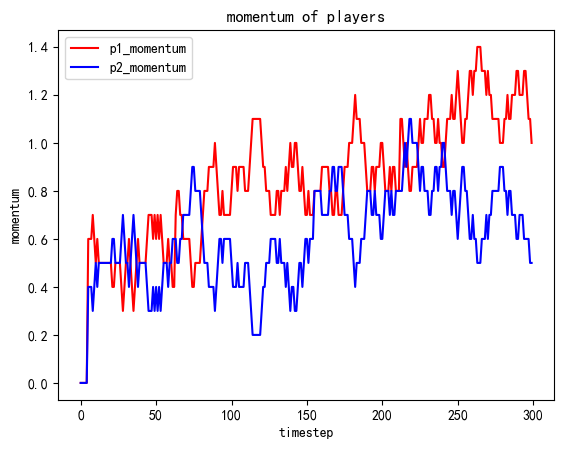

In [236]:
p1_momentum = momentum_true(df, 1)
p2_momentum = momentum_true(df, 2)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('momentum of players')
plt.xlabel('timestep')
plt.ylabel('momentum')

plt.plot(p1_momentum, color='red',label='p1_momentum')
plt.plot(p2_momentum, color='blue',label='p2_momentum')
plt.legend()

In [ ]:
# 先平滑, 加入arima
from scipy.signal import savgol_filter
from statsmodels.tsa.arima.model import ARIMA

def arima_predict(player:int,end=-1, return_p_points=False):
    window_size = 5  # 窗口大小
    poly_order = 2  # 多项式拟合阶数
    p_points = savgol_filter(df['p{}_points_won'.format(player)], window_size, poly_order)
    model = ARIMA(endog=p_points, order=(2,1,2))
    model_fit = model.fit()
    end = len(p_points)-1 if end == -1 else end
    predictions = list(model_fit.predict(start=0,end=end))
    if return_p_points == True:
        return predictions, p_points
    return predictions

mse = 0.07641544624405458


c:\Users\Lithium\OneDrive\桌面\preMCM\.env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


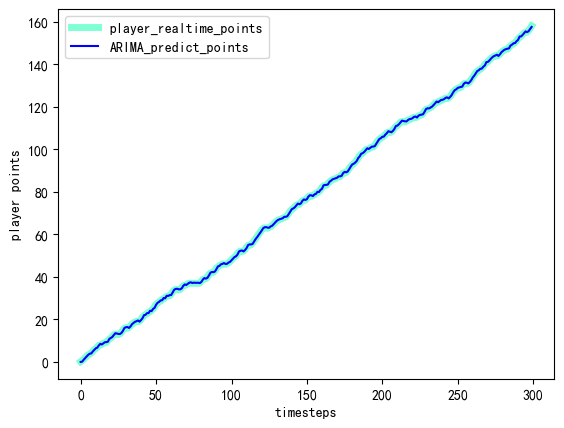

In [ ]:
# 画图看预测曲线
p1_pred_score, p1_real_score = arima_predict(1, return_p_points=True)

plt.xlabel('timesteps')
plt.ylabel('player points')
plt.plot(p1_real_score, color='aquamarine', linewidth=5, label='player_realtime_points')
plt.plot(p1_pred_score, color='blue', label='ARIMA_predict_points')
plt.legend ()

# mse
print("mse = {}".format(sum( [(i-j)**2 for i, j in zip(p1_real_score, p1_pred_score)] )/len(p1_pred_score)))


In [ ]:
l,h = 0, 0
cntl, cnth = 0, 0
for i,j in zip(p1_real_score, p1_pred_score):
    if i > j:
        l += i-j
        cntl += 1
    if i < j:
        h += j-i
        cnth += 1
print("low = {}, high = {}".format(l/cntl, h/cnth))



low = 0.2327342734409017, high = 0.22740798865009257


In [ ]:
def calculate_mape(actual_values, predicted_values):
    n = len(actual_values)
    mape = (1/n) * sum(abs((actual - predicted) / actual) * 100 for actual, predicted in zip(actual_values, predicted_values))
    return mape

# Example usage:
actual_values = p1_real_score
predicted_values = p1_pred_score

mape_result = calculate_mape(actual_values, predicted_values)
print(f"MAPE: {mape_result}%")

MAPE: 1.2540565704850763%


In [ ]:
order_analyze

{'aic':              0            1            2            3            4  \
 0  3143.079551  2737.968368  2356.048687  1986.074088  1766.990098   
 1   588.525715   350.180016   136.909973   137.889205   129.914081   
 2   202.014319   524.816885   137.910004   138.467810   139.945214   
 3          NaN   202.950818   187.064942   143.563650   142.414471   
 4   403.491914   198.069265   209.485504   124.966075   142.618392   
 5   187.775678    37.026042   192.954724    97.908358    40.125399   
 
              5  
 0  1438.091522  
 1   113.094597  
 2   129.375703  
 3   143.172728  
 4   142.874361  
 5   141.021679  ,
 'bic':              0            1            2            3            4  \
 0  3150.487116  2749.079716  2370.863817  2004.593000  1789.212793   
 1   599.637062   364.995146   155.428885   160.111900   155.840558   
 2   216.829449   543.335797   160.132699   164.394288   169.575473   
 3          NaN   225.173513   212.991419   173.193909   175.748514   
 4   

In [ ]:
# 近似的动量
def momentum(single_df, player:int):
    res = []
    player_score = single_df['point_victor']
    player_score_prediction = arima_predict(player)
    n = len(player_score)
    for i in range(n):
        cur_momentum = sum([j==player for j in player_score[i-5:i]+player_score_prediction[i:i+5]]) / 10 + 0.2 # 修正因子
        if df['server'] == player:
           cur_momentum += 0.067
        cur_momentum += single_df['p{}_sets'.format(player)][i] * 0.3
        res.append(cur_momentum)
    return res

c:\Users\Lithium\OneDrive\桌面\preMCM\.env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Lithium\OneDrive\桌面\preMCM\.env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


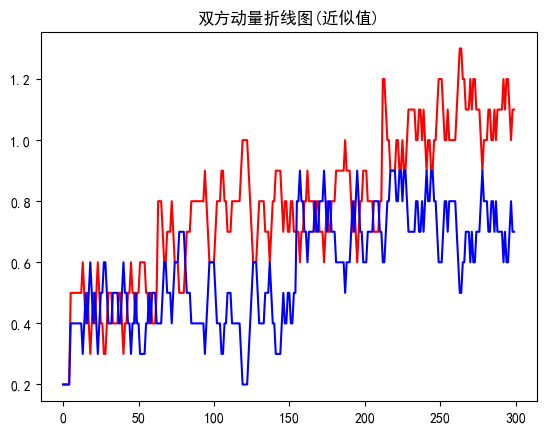

In [ ]:
p1_momentum = momentum(df, 1)
p2_momentum = momentum(df, 2)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('双方动量折线图(近似值)')
plt.plot(p1_momentum, color='red')
plt.plot(p2_momentum, color='blue')

## 第三题: 开发模型预测什么迹象表明比赛开始对某方有利
分类, 比分 **快速** 接近并 **反超** 的地方就是转折点

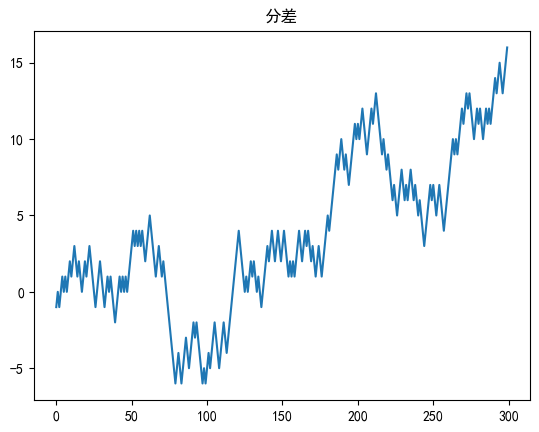

In [ ]:
# 分差可视化
from itertools import pairwise
score_dif = np.array(df['p1_points_won']) - np.array(df['p2_points_won'])
score_dif = score_dif.tolist()

discard_score_dif = score_dif   # 备用, 离散值
discard_derive_score_dif = [0]+[i-j for i,j in pairwise(discard_score_dif)]# 备用, 离散值

plt.title("分差")
plt.plot(score_dif)

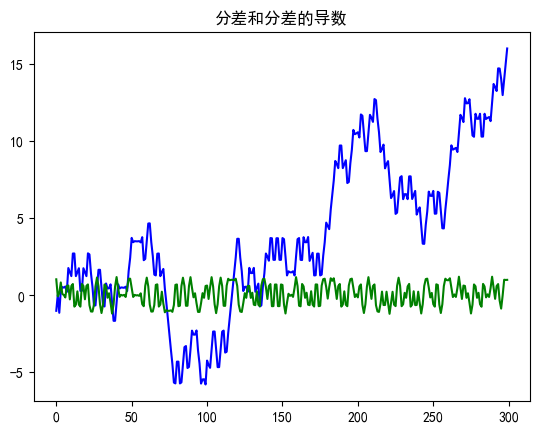

In [ ]:
# 平滑分差
from numpy import gradient
from collections import Counter
turning_points = []
window_size = 10  # 窗口大小
poly_order = 8  # 多项式拟合阶数
score_dif = savgol_filter(score_dif, window_size, poly_order)
derive_of_score_dif = gradient(score_dif)
        
plt.title("分差和分差的导数")
plt.plot(score_dif, color='blue')
plt.plot(derive_of_score_dif, color='green')

0.0600789798437704 0.07877124518306663 0.6868794576757453 0.828781912010479
1.205062866210456


(array([ 8.,  1.,  0., 27., 40., 11.,  0.,  3., 15., 14., 11., 12., 10.,
         5.,  0., 18., 43., 25.,  1.,  1., 14., 16.,  8.,  0.,  0.]),
 array([-1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35, -0.25,
        -0.15, -0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,
         0.75,  0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45]),
 <BarContainer object of 25 artists>)

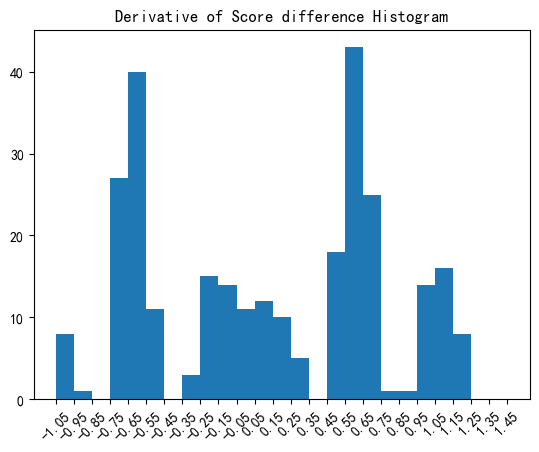

In [ ]:
# 确定导数阈值: +-0.75 或者 分差0附近且+-0.5
print(derive_of_score_dif.mean(), np.median(derive_of_score_dif), np.std(derive_of_score_dif), np.sqrt(np.std(derive_of_score_dif)))
print(max(derive_of_score_dif))
x = [i*0.1+0.05 for i in range(-int(1.2/0.1), int(1.5/0.1))]
plt.title("Derivative of Score difference Histogram")
plt.xticks(x, rotation=45)
plt.hist(derive_of_score_dif, bins=x)

(array([ 8., 12., 10., 10.,  6., 10., 32., 35., 29., 27.,  9., 11., 19.,
         9., 11., 13., 13., 19.,  8.,  3.,  5.]),
 array([-6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,
         7.,  8.,  9., 10., 11., 12., 13., 14., 15.]),
 <BarContainer object of 21 artists>)

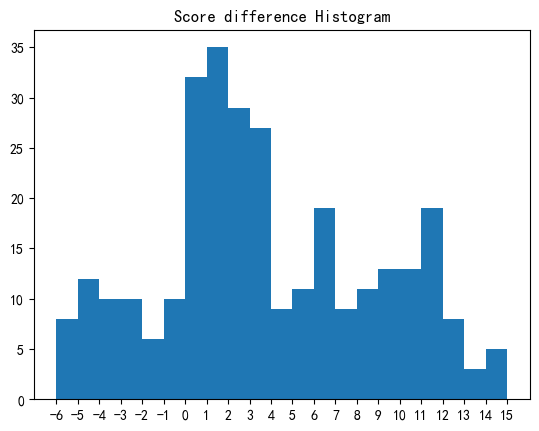

In [ ]:
# 确定分差0附近是什么意思: -1, 0, +1
x = [i for i in range(-6,16)]
plt.title("Score difference Histogram")
plt.xticks(x)
plt.hist(score_dif, bins=x)

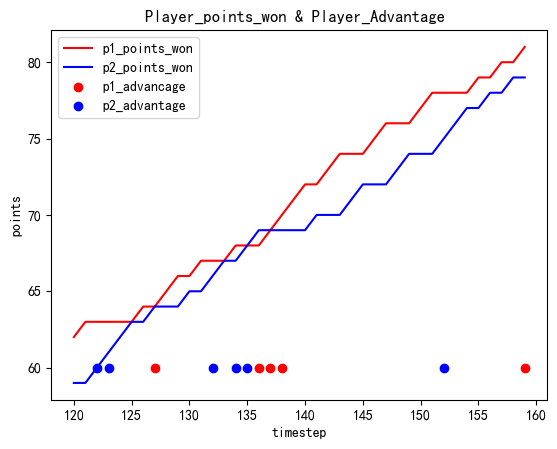

In [ ]:
# 标签 Y 
n = len(score_dif)
Y = [0]*n
for i in range(n):
    if abs(derive_of_score_dif[i])>=0.75 or abs(score_dif[i])<=1 and abs(derive_of_score_dif[i])>=0.55:
        if derive_of_score_dif[i]>0:
            Y[i] = 1
        else:
            Y[i] = 2

# 查看be区间
b, e = 120, 160
up_line, base_line = 60, 50
x = list(range(b,e))

# p1-p2优势区 离散图
## 离散图y
p1_Y, p2_Y = [], []
for i in Y:
    if i == 0:
        p1_Y.append(0)
        p2_Y.append(0)
    elif i == 1:
        p1_Y.append(up_line)
        p2_Y.append(0)
    else:
        p2_Y.append(up_line)
        p1_Y.append(0)
## 离散图x
p1_scatter_x = []
p2_scatter_x = []
for i in x:
    if p1_Y[i]>0:
        p1_scatter_x.append(i)
    if p2_Y[i]>0:
        p2_scatter_x.append(i)
p1_Y, p2_Y = [up_line]*len(p1_scatter_x), [up_line]*len(p2_scatter_x)
plt.title("Player_points_won & Player_Advantage ")
plt.ylabel('points')
plt.xlabel('timestep')
plt.plot(x,df['p1_points_won'][b:e],color='red',label="p1_points_won")
plt.plot(x,df['p2_points_won'][b:e],color='blue',label="p2_points_won")
# plt.plot(x,[i*5+base_line for i in discard_derive_score_dif[b:e]],color='green')
plt.scatter(p1_scatter_x,p1_Y, color='red',label='p1_advancage')
plt.scatter(p2_scatter_x,p2_Y, color='blue',label='p2_advantage')
plt.legend()

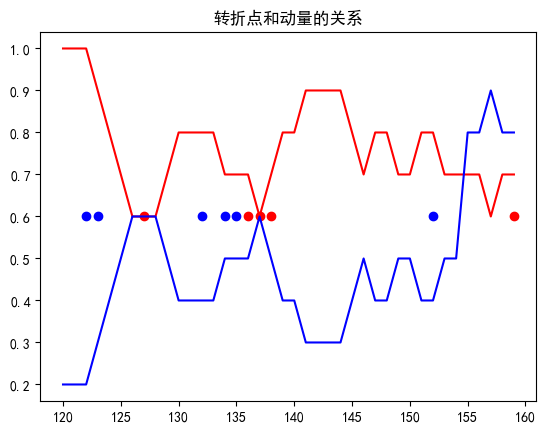

In [ ]:
# 转折点和动量的关系
p1_Y = np.array(p1_Y)-up_line+0.6
p2_Y = np.array(p2_Y)-up_line+0.6
plt.title("转折点和动量的关系")
plt.plot(x,p1_momentum[b:e],color='red')
plt.plot(x,p2_momentum[b:e],color='blue')
plt.scatter(p1_scatter_x,p1_Y, color='red')
plt.scatter(p2_scatter_x,p2_Y, color='blue')

#### 定义完转折点, 用xgboost

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from pandas import read_csv
import numpy as np
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn import metrics
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from xgboost import XGBClassifier, plot_importance
import warnings
import seaborn as sns

In [ ]:
# 标签: Y [0(波动),1(对p1有利),2(对p2有利)]
# features: 已有标签, single_df和2024c\traintestds\2023-wimbledon-1301融合, 手工去掉一些特征, 得到all_int文件
# single_df_all_int原有标签:
# match_id,player1,player2,elapsed_time,set_no,game_no,
# point_no,p1_sets,p2_sets,p1_games,p2_games,p1_score,p2_score,
# server,serve_no,point_victor,p1_points_won,p2_points_won,
# game_victor,set_victor,p1_ace,p2_ace,p1_winner,p2_winner,
# winner_shot_type,p1_double_fault,p2_double_fault,p1_unf_err,p2_unf_err,
# p1_net_pt,p2_net_pt,p1_net_pt_won,p2_net_pt_won,p1_break_pt,p2_break_pt,
# p1_break_pt_won,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,
# p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,
# serve_depth,return_depth,score_dif_p1,score_dif_p2,server_p1,server_p2,p1_ad,p2_ad,
# p1_comble,p2_comble,p1_break_points,p2_break_points,p1_break_points_won,p2_break_points_won,
# p1_win_possiblity,p2_win_possiblity
# 改动: 不要p_win_possiblity,加入p_momentum

cur_fp = 'data/single_df_all_int.csv'
dataset = pd.read_csv('data/single_df_all_int.csv')
dft = pd.read_csv(cur_fp).to_dict()
for i, j in dft.items():
    if isinstance(j, dict):
        dft[i] = [k for _,k in j.items()]
# 加入动量! 
dataset['p1_momentum'] = momentum(dft,1)
dataset['p2_momentum'] = momentum(dft,2)
dataset.describe()

c:\Users\Lithium\OneDrive\桌面\preMCM\.env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Lithium\OneDrive\桌面\preMCM\.env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,p1_points_won,p2_points_won,p1_sets,p2_sets,p1_games,p2_games,server,serve_no,point_victor,game_victor,...,p2_break_pt_missed,rally_count,score_dif_p1,score_dif_p2,p1_comble,p2_comble,p1_win_possiblity,p2_win_possiblity,p1_momentum,p2_momentum
count,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000,...,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000,3194.000000
mean,66.022229,65.810895,0.794302,0.736068,2.500626,2.500939,1.508766,1.345961,1.494678,0.240451,...,0.020351,3.125861,0.026363,-0.026363,-0.004244,-0.007033,0.899155,0.868973,0.690482,0.667846
std,43.059436,40.848424,0.816725,0.742539,1.872084,1.868735,0.500001,0.475755,0.500050,0.584092,...,0.141219,3.166207,0.967255,0.967255,0.992130,0.987058,0.705090,0.628196,0.280346,0.250554
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,-2.818067,-2.926751,-0.454543,-0.498445,0.000000,0.000000,0.200000,0.200000
25%,31.000000,32.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,-0.666817,-0.785371,-0.432482,-0.420777,0.500000,0.500000,0.500000,0.500000
50%,60.000000,63.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,...,0.000000,2.000000,-0.022754,0.022754,-0.416655,-0.393146,0.700000,0.700000,0.600000,0.600000
75%,97.000000,97.000000,2.000000,1.000000,4.000000,4.000000,2.000000,2.000000,2.000000,0.000000,...,0.000000,4.000000,0.785371,0.666817,-0.333947,-0.368470,1.100000,1.000000,0.900000,0.800000
max,176.000000,166.000000,2.000000,2.000000,6.000000,6.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,30.000000,2.926751,2.818067,6.675634,6.090777,5.000000,5.000000,1.300000,1.300000


In [ ]:
# 热力图
heatdf = pd.DataFrame(df)
heatdf['Y'] = Y
heatdf['p1_momentum'] = np.array(p1_momentum)
heatdf['p2_momentum'] = np.array(p2_momentum)
heatdf.drop("match_id	player1	player2	elapsed_time p1_score	p2_score winner_shot_type serve_width serve_depth	return_depth p1_ad p2_ad".split(), axis=1, inplace=True)
# heatdf.head(20)
heatdf.columns

Index(['set_no', 'game_no', 'point_no', 'p1_sets', 'p2_sets', 'p1_games',
       'p2_games', 'server', 'serve_no', 'point_victor', 'p1_points_won',
       'p2_points_won', 'game_victor', 'set_victor', 'p1_ace', 'p2_ace',
       'p1_winner', 'p2_winner', 'p1_double_fault', 'p2_double_fault',
       'p1_unf_err', 'p2_unf_err', 'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won',
       'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won',
       'p2_break_pt_won', 'p1_break_pt_missed', 'p2_break_pt_missed',
       'p1_distance_run', 'p2_distance_run', 'rally_count', 'speed_mph',
       'score_dif_p1', 'score_dif_p2', 'server_p1', 'server_p2', 'p1_comble',
       'p2_comble', 'p1_break_points', 'p2_break_points',
       'p1_break_points_won', 'p2_break_points_won', 'p1_win_possiblity',
       'p2_win_possiblity', 'Y', 'p1_momentum', 'p2_momentum'],
      dtype='object')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

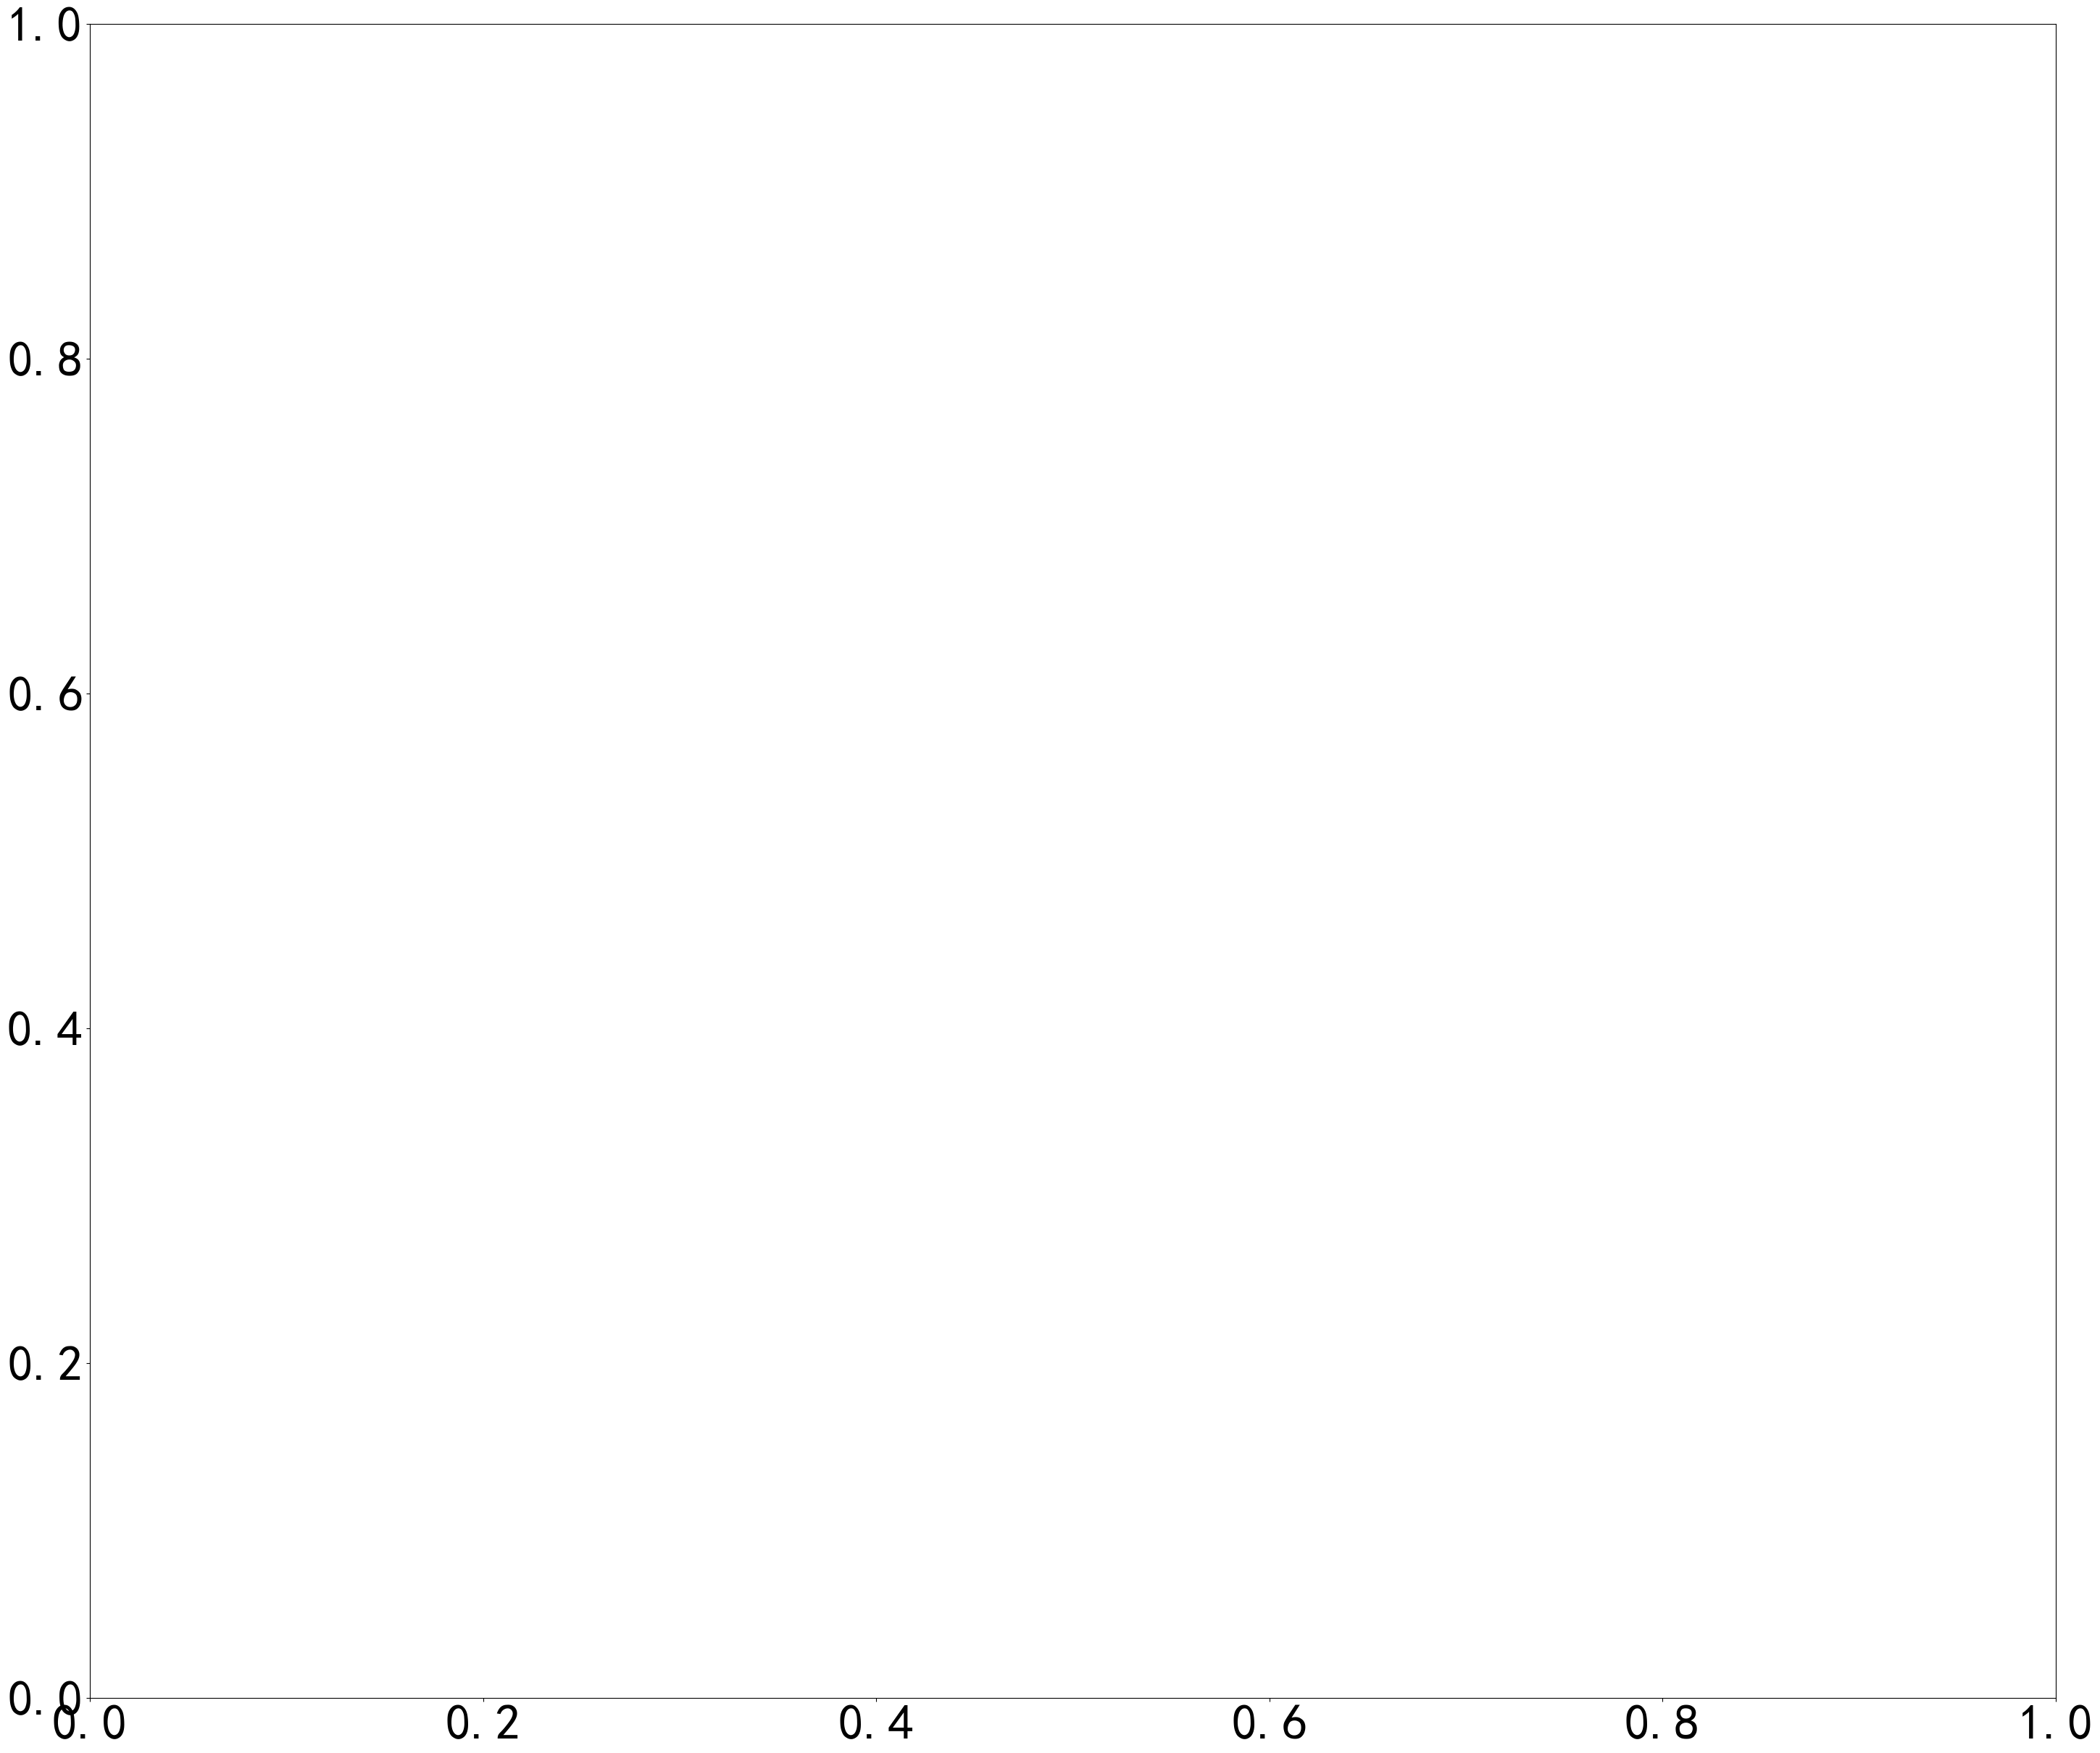

In [ ]:

plt.figure(figsize=(35,30))
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
# sns.heatmap(heatdf.corr(), xticklabels=True, yticklabels=True, annot=True)

In [ ]:
score_dif = np.array(dft['p1_points_won']) - np.array(dft['p2_points_won'])
dataset.drop(['p2_points_won','p1_points_won','p1_win_possiblity','p2_win_possiblity'],axis=1, inplace=True) # 看着俩就是作弊了
dft.pop('p1_points_won')
dft.pop('p2_points_won')
score_dif = score_dif.tolist()
turning_points = []
window_size = 10  # 窗口大小
poly_order = 8  # 多项式拟合阶数
score_dif = savgol_filter(score_dif, window_size, poly_order)
derive_of_score_dif = gradient(score_dif)
n = len(score_dif)
Y = [0]*n
for i in range(n):
    if abs(derive_of_score_dif[i])>=0.75 or abs(score_dif[i])<=1 and abs(derive_of_score_dif[i])>=0.55:
        if derive_of_score_dif[i]>0:
            Y[i] = 1
        else:
            Y[i] = 2
# 数据集
def get_ds(df:pd.DataFrame):
    x = []# 特征数据
    print({i:j for i,j in enumerate(df.columns)})
    for index in df.index.values:
        x.append(df.loc[index].values)
    x = np.array(x)
    return x
X = get_ds(dataset)
assert len(X) == len(Y) 
## 训练验证集
n = len(Y)
x_train, x_test = X[:-n//8], X[-n//8:]
y_train, y_test = Y[:-n//8], Y[-n//8:]
print(len(x_test[0]))

{0: 'p1_sets', 1: 'p2_sets', 2: 'p1_games', 3: 'p2_games', 4: 'server', 5: 'serve_no', 6: 'point_victor', 7: 'game_victor', 8: 'set_victor', 9: 'p1_ace', 10: 'p2_ace', 11: 'p1_winner', 12: 'p2_winner', 13: 'p1_double_fault', 14: 'p2_double_fault', 15: 'p1_unf_err', 16: 'p2_unf_err', 17: 'p1_net_pt', 18: 'p2_net_pt', 19: 'p1_net_pt_won', 20: 'p2_net_pt_won', 21: 'p1_break_pt', 22: 'p2_break_pt', 23: 'p1_break_pt_won', 24: 'p2_break_pt_won', 25: 'p1_break_pt_missed', 26: 'p2_break_pt_missed', 27: 'rally_count', 28: 'score_dif_p1', 29: 'score_dif_p2', 30: 'p1_comble', 31: 'p2_comble', 32: 'p1_momentum', 33: 'p2_momentum'}
34


In [ ]:
# fit
params = {'objective':'multi:softmax',
    'n_estimators': 100, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.1, 'colsample_bytree': 1,
                'subsample': 1, 'reg_alpha': 0.01, 'reg_lambda': 3, 'learning_rate': 0.3}
xgb= XGBClassifier(params)
xgb.fit(x_train, y_train)

c:\Users\Lithium\OneDrive\桌面\preMCM\.env\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

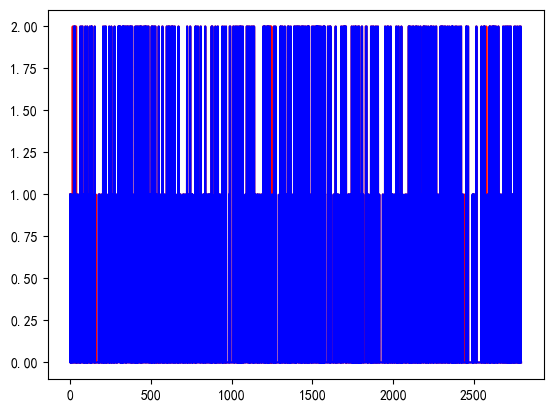

In [ ]:
# 检查训练集拟合情况
b, e = 0, -1
y_train_pred = xgb.predict(x_train)
plt.plot(y_train[b:e], color='red')
plt.plot(y_train_pred[b:e], color='blue')

acc: 65.0%


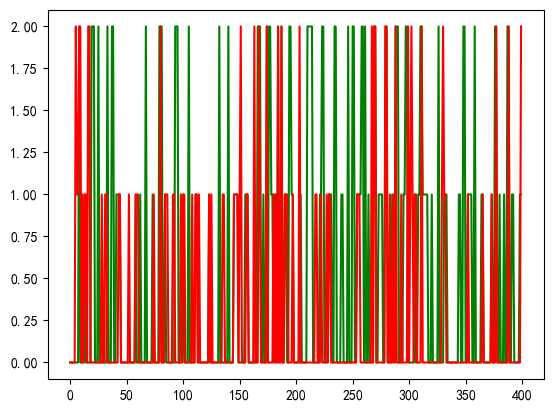

In [ ]:
# 验证即拟合情况
y_pred = xgb.predict(x_test)
plt.plot(y_test, color='green')
plt.plot(y_pred, color='red')
# 准确率
acc = 0
for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
        acc += 1
print("acc: {}%".format(acc*100/len(y_pred)))

特征重要性: ['score_dif_p1', 'rally_count', 'p1_comble', 'p2_comble', 'p2_games', 'p1_games', 'p1_momentum', 'p2_momentum', 'score_dif_p2', 'serve_no', 'server', 'p1_sets', 'p2_sets', 'point_victor', 'p1_winner', 'p1_net_pt', 'p2_unf_err', 'p1_unf_err', 'game_victor', 'p2_winner', 'p2_net_pt', 'p1_ace', 'p2_ace', 'set_victor', 'p1_net_pt_won', 'p1_break_pt', 'p1_double_fault', 'p2_break_pt', 'p2_net_pt_won', 'p1_break_pt_missed', 'p2_break_pt_won', 'p2_break_pt_missed', 'p2_double_fault', 'p1_break_pt_won']
特征重要性: [('f28', 1997.0), ('f27', 906.0), ('f30', 837.0), ('f31', 830.0), ('f3', 795.0), ('f2', 765.0), ('f32', 676.0), ('f33', 667.0), ('f29', 288.0), ('f5', 279.0), ('f4', 183.0), ('f0', 176.0), ('f1', 148.0), ('f6', 145.0), ('f11', 132.0), ('f17', 123.0), ('f16', 122.0), ('f15', 102.0), ('f7', 101.0), ('f12', 96.0), ('f18', 81.0), ('f9', 54.0), ('f10', 47.0), ('f8', 46.0), ('f19', 36.0), ('f21', 33.0), ('f13', 31.0), ('f22', 31.0), ('f20', 28.0), ('f25', 23.0), ('f24', 19.0), ('f26', 1

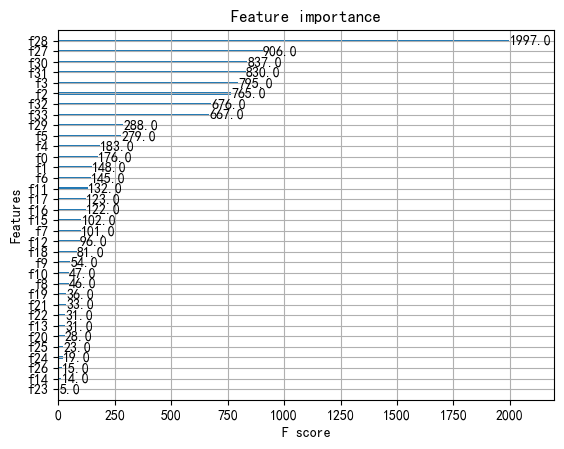

In [ ]:
# 重要特征
dic = {'f{}'.format(i):j for i,j in enumerate(dataset.columns)}
def feature_importance_selected(clf_model):
    """模型特征重要性提取与保存"""
    # 模型特征重要性打印和保存
    feature_importance = clf_model.get_booster().get_fscore()
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    print('特征重要性:', [dic.get(i[0], i[0]) for i in feature_importance])
    print('特征重要性:', feature_importance)

    # 模型特征重要性绘图
    plot_importance(xgb)
    plt.show()

feature_importance_selected(xgb)

In [ ]:

from sklearn.metrics import precision_score, recall_score,roc_curve
def metrics_sklearn(y_valid, y_pred_):
    """模型对验证集和测试集结果的评分"""
    # 准确率
    accuracy = accuracy_score(y_valid, y_pred_)
    print('Accuracy：%.2f%%' % (accuracy * 100))

    # 精准率
    precision = precision_score(y_valid, y_pred_, average='weighted')
    print('Precision：%.2f%%' % (precision * 100))

    # 召回率
    recall = recall_score(y_valid, y_pred_, average='weighted')
    print('Recall：%.2f%%' % (recall * 100))

    # F1值
    f1 = f1_score(y_valid, y_pred_, average='weighted')
    print('F1：%.2f%%' % (f1 * 100))

    # auc曲线下面积
    # auc = roc_auc_score(y_valid, y_pred_, average='micro')
    # print('AUC：%.2f%%' % (auc * 100))

    # ks值
    # fpr, tpr, thresholds = roc_curve(y_valid, y_pred_, average='micro')
    # ks = max(abs(fpr - tpr))
    # print('KS：%.2f%%' % (ks * 100))
    return accuracy, precision, recall, f1
metrics_sklearn(y_test, y_pred)

Accuracy：65.00%
Precision：63.00%
Recall：65.00%
F1：62.69%


(0.65, 0.6300226255343179, 0.65, 0.6268593234045421)

### 用xgboost预测转折点

In [ ]:
def creat_all_int():
    dir1 = ['../2024c/traintestds/'+i for i in os.listdir('../2024c/traintestds')]
    dir2 = ['../2024c/processed_data/origin/'+i for i in os.listdir('../2024c/processed_data/origin/')]
    all_features = ['p1_points_won','p2_points_won','p1_sets','p2_sets','p1_games','p2_games','server','serve_no','point_victor','game_victor','set_victor','p1_ace','p2_ace','p1_winner','p2_winner','p1_double_fault','p2_double_fault','p1_unf_err','p2_unf_err','p1_net_pt','p2_net_pt','p1_net_pt_won','p2_net_pt_won','p1_break_pt','p2_break_pt','p1_break_pt_won','p2_break_pt_won','p1_break_pt_missed','p2_break_pt_missed','rally_count','score_dif_p1','score_dif_p2','p1_comble','p2_comble','p1_momentum','p2_momentum']
    def format_df(pth):
        df = read_csv(pth).to_dict()
        for idx,val in df.items():
            if isinstance(val, dict):
                df[idx] = [i for _,i in val.items()]
        return df

    for i, (j, k) in enumerate(zip(dir1, dir2)):
        # 获取动量
        df1, df2 = format_df(j), format_df(k)
        
        p1_momentum = momentum_true(df2, 1)
        p2_momentum = momentum_true(df2, 2)

        cols = {}
        for feature in all_features:
            try:
                cols[feature] = df1[feature]
            except:
                try:
                    cols[feature] = df2[feature]
                except:
                    if feature == 'p1_momentum':
                        cols[feature] = p1_momentum
                    elif feature == 'p2_momentum':
                        cols[feature] = p2_momentum
                    else:
                        print(feature)
                        raise KeyError
        pd.DataFrame(cols).to_csv('./data/df_all_int/match{}.csv'.format(i))
            

creat_all_int()

In [ ]:

from numpy import gradient
def xgboost_valid(xgb, pth='./data/df_all_int/'):
    accuracy= precision= recall= f1 = 0
    match_n = len(os.listdir(pth))
    cnt = 0
    for i in range(match_n):
        cur_fp = pth+os.listdir(pth)[i]
        assert os.path.isfile(cur_fp)
        single_df = read_csv(cur_fp,index_col=[0])

        # 标签
        def get_label(single_df):
            score_dif = np.array(single_df['p1_points_won']) - np.array(single_df['p2_points_won'])
            score_dif = score_dif.tolist()
            window_size = 10  # 窗口大小
            poly_order = 8  # 多项式拟合阶数
            score_dif = savgol_filter(score_dif, window_size, poly_order)
            derive_of_score_dif = gradient(score_dif)
            n = len(score_dif)
            Y = [0]*n
            for i in range(n):
                if abs(derive_of_score_dif[i])>=0.75 or abs(score_dif[i])<=1 and abs(derive_of_score_dif[i])>=0.55:
                    if derive_of_score_dif[i]>0:
                        Y[i] = 1
                    else:
                        Y[i] = 2
            return Y
        y_valid = get_label(single_df)
        single_df.drop(['p1_points_won','p2_points_won'],axis=1, inplace=True)

        # 特征
        def get_ds(single_df):
            x = []# 特征数据
            try:
                assert list({i:j for i,j in enumerate(single_df.columns)}.values()) == list({0: 'p1_sets', 1: 'p2_sets', 2: 'p1_games', 3: 'p2_games', 4: 'server', 5: 'serve_no', 6: 'point_victor', 7: 'game_victor', 8: 'set_victor', 9: 'p1_ace', 10: 'p2_ace', 11: 'p1_winner', 12: 'p2_winner', 13: 'p1_double_fault', 14: 'p2_double_fault', 15: 'p1_unf_err', 16: 'p2_unf_err', 17: 'p1_net_pt', 18: 'p2_net_pt', 19: 'p1_net_pt_won', 20: 'p2_net_pt_won', 21: 'p1_break_pt', 22: 'p2_break_pt', 23: 'p1_break_pt_won', 24: 'p2_break_pt_won', 25: 'p1_break_pt_missed', 26: 'p2_break_pt_missed', 27: 'rally_count', 28: 'score_dif_p1', 29: 'score_dif_p2', 30: 'p1_comble', 31: 'p2_comble', 32: 'p1_momentum', 33: 'p2_momentum'}.values())
            except:
                print({i:j for i,j in enumerate(single_df.columns)})
                print({0: 'p1_sets', 1: 'p2_sets', 2: 'p1_games', 3: 'p2_games', 4: 'server', 5: 'serve_no', 6: 'point_victor', 7: 'game_victor', 8: 'set_victor', 9: 'p1_ace', 10: 'p2_ace', 11: 'p1_winner', 12: 'p2_winner', 13: 'p1_double_fault', 14: 'p2_double_fault', 15: 'p1_unf_err', 16: 'p2_unf_err', 17: 'p1_net_pt', 18: 'p2_net_pt', 19: 'p1_net_pt_won', 20: 'p2_net_pt_won', 21: 'p1_break_pt', 22: 'p2_break_pt', 23: 'p1_break_pt_won', 24: 'p2_break_pt_won', 25: 'p1_break_pt_missed', 26: 'p2_break_pt_missed', 27: 'rally_count', 28: 'score_dif_p1', 29: 'score_dif_p2', 30: 'p1_comble', 31: 'p2_comble', 32: 'p1_momentum', 33: 'p2_momentum'})
                return

            for index in single_df.index.values:
                x.append(single_df.loc[index].values)
            x = np.array(x)
            return x
        x_valid = get_ds(single_df)

        # xgb预测
        y_pred = xgb.predict(x_valid)

        # 画图

        # 检验
        print('test on match{}: '.format(i))
        a,b,c,d = metrics_sklearn(y_valid, y_pred)
        # if a > 0.85:
        #     cnt += 1
        # else:
        accuracy, precision, recall, f1 = accuracy+a,precision+b,recall+c,f1+d
        if i == 24:
            return y_valid, y_pred


    match_n -= cnt
    print('avg_metricx')
    print('Accuracy：%.2f%%' % (accuracy * 100/match_n))
    print('Precision：%.2f%%' % (precision * 100/match_n))
    print('Recall：%.2f%%' % (recall * 100/match_n))
    print('F1：%.2f%%' % (f1 * 100/match_n))
y24r, y24p = xgboost_valid(xgb)
# xgboost_valid(xgb)


test on match0: 
Accuracy：76.33%
Precision：72.88%
Recall：76.33%
F1：72.56%
test on match1: 
Accuracy：90.55%
Precision：90.95%
Recall：90.55%
F1：90.11%
test on match2: 
Accuracy：90.00%
Precision：90.04%
Recall：90.00%
F1：89.83%
test on match3: 
Accuracy：90.55%
Precision：91.05%
Recall：90.55%
F1：90.09%
test on match4: 
Accuracy：91.38%
Precision：91.30%
Recall：91.38%
F1：91.00%
test on match5: 
Accuracy：67.03%
Precision：61.46%
Recall：67.03%
F1：63.08%
test on match6: 
Accuracy：91.41%
Precision：91.81%
Recall：91.41%
F1：90.98%
test on match7: 
Accuracy：66.47%
Precision：65.30%
Recall：66.47%
F1：65.82%
test on match8: 
Accuracy：64.44%
Precision：58.98%
Recall：64.44%
F1：58.22%
test on match9: 
Accuracy：62.41%
Precision：57.95%
Recall：62.41%
F1：58.20%
test on match10: 
Accuracy：48.36%
Precision：51.97%
Recall：48.36%
F1：43.96%
test on match11: 
Accuracy：93.71%
Precision：93.98%
Recall：93.71%
F1：93.47%
test on match12: 
Accuracy：88.81%
Precision：88.80%
Recall：88.81%
F1：88.59%
test on match13: 
Accuracy：52.56%
P

In [ ]:

(y24p,  y24r)
pth24 = '../2024c/processed_data/2023-wimbledon-1501'
df24 = read_csv(pth24)

In [ ]:
p1, p2 = df24['p1_points_won'].tolist(), df24['p2_points_won'].tolist()


In [ ]:
def f(Y):
    p1_Y, p2_Y = [], []
    for i in Y:
        if i == 0:
            p1_Y.append(0)
            p2_Y.append(0)
        elif i == 1:
            p1_Y.append(up_line)
            p2_Y.append(0)
        else:
            p2_Y.append(up_line)
            p1_Y.append(0)
    ## 离散图x
    p1_scatter_x = []
    p2_scatter_x = []
    for i in x:
        if p1_Y[i]>0:
            p1_scatter_x.append(i)
        if p2_Y[i]>0:
            p2_scatter_x.append(i)
    p1_Y, p2_Y = [up_line]*len(p1_scatter_x), [up_line]*len(p2_scatter_x)
    return p1_scatter_x, p2_scatter_x, p1_Y, p2_Y


ValueError: x and y must have same first dimension, but have shapes (40,) and (189,)

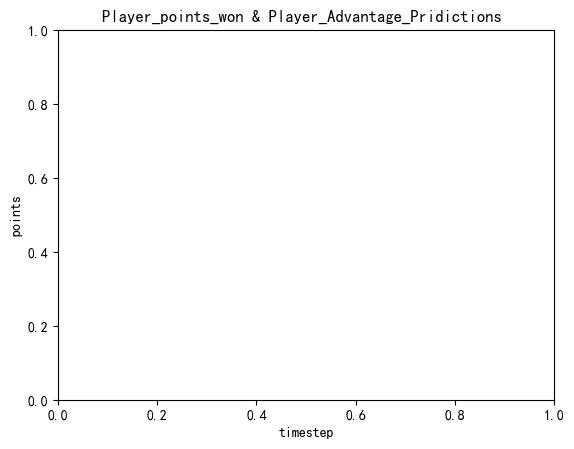

In [ ]:
b, e = 100, 200
plt.title("Player_points_won & Player_Advantage_Pridictions ")
plt.ylabel('points')
plt.xlabel('timestep')
plt.plot(x,p1,color='red',label="p1_points_won")
plt.plot(x,p2,color='blue',label="p2_points_won")
p1x, p2x, rp1,rp2 = f(y24r)
plt.scatter(p1x,rp1, color='red',label='real_p1_advancage')
plt.scatter(p2x,rp2, color='blue',label='real_p2_advantage')
p1x, p2x, pp1,pp2 = f(y24p)
plt.scatter(p1x,pp1, color='green',label='pridict_p1_advancage')
plt.scatter(p2x,pp2, color='yellow',label='pridict_p2_advantage')
plt.legend()

In [240]:
feature_rank= {'score_dif_p1': 906.0, 'p1_momentum': 837.0, 'p2_momentum': 830.0, 'p1_comble': 795.0, 'p2_comble': 765.0, 'server': 676.0, 'score_dif_p2': 667.0}

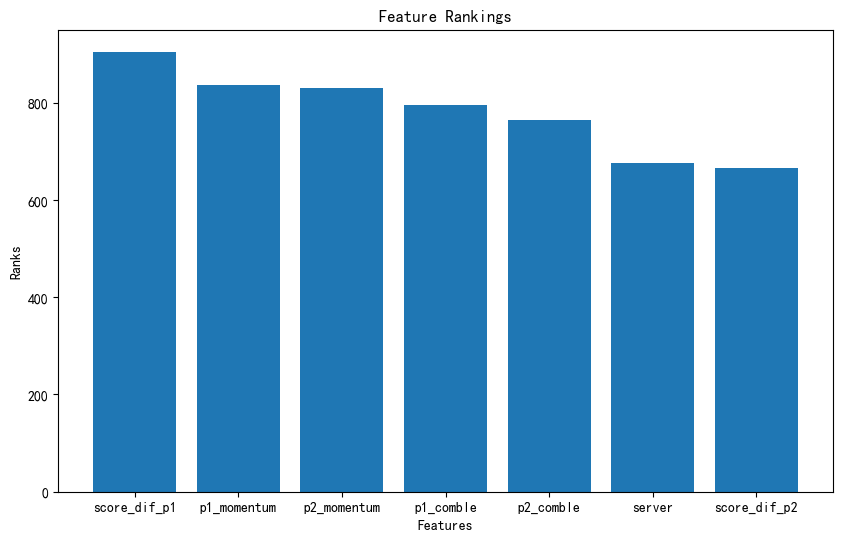

In [242]:
import matplotlib.pyplot as plt

# 特征和排名字典
feature_rank = {'score_dif_p1': 906.0, 'p1_momentum': 837.0, 'p2_momentum': 830.0, 'p1_comble': 795.0, 'p2_comble': 765.0, 'server': 676.0, 'score_dif_p2': 667.0}

# 将特征和排名分别存储为列表
features = list(feature_rank.keys())
ranks = list(feature_rank.values())

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制条形图
plt.bar(range(len(features)), ranks, align='center')

# 设置特征作为x轴刻度
plt.xticks(range(len(features)), features)

# 添加标题和轴标签
plt.title('Feature Rankings')
plt.xlabel('Features')
plt.ylabel('Ranks')

# 显示图形
plt.show()